## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensiones, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [1]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [3]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

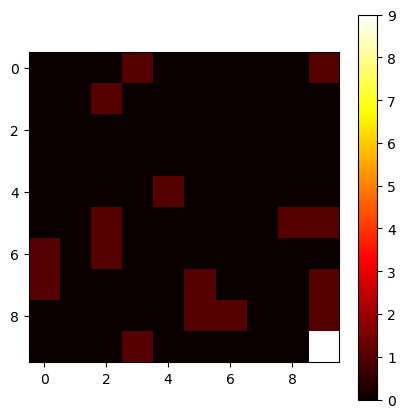

In [4]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [5]:
alpha = 0.1
gamma = 0.99
epsilon = 0.2
episodios = 1000

##### 2. Función para elegir acciones equilibrando entre explotación y exploración

In [6]:
def elegir_accion(Q, estado):
    if random.uniform(0, 1) < epsilon:
        #Asumiendo 4 acciones posibles (0, 3)
        return random.randint(0, 3)   
    else:
        #'Estado' como índice lineal de Q 
        return np.argmax(Q[estado])

##### 3. Función para simular la acción en el laberinto

In [7]:
def ejecutar_accion(estado, accion, tamanio, laberinto):
    
    # Asignar una posición en el laberinto, en función del estado y el tamaño del laberinto  
    fila, columna = divmod(estado, tamanio)
    
    # Definición: 0 = 'arriba', 1 = 'abajo', 2 = 'izquierda', 3 = 'derecha'
    if accion == 0 and fila > 0:
        fila -= 1                              #arriba
    elif accion == 1 and fila < tamanio - 1 :
        fila += 1                              #abajo
    elif accion == 2 and columna > 0:
        columna -= 1                           #izquierda
    elif accion == 3 and columna < tamanio - 1:
        columna += 1                           #derecha

    # Definir el nuevo estado en que quedará el agente en el laberinto
    estado_futuro = fila * tamanio + columna

    # Establecer las recompensas y las penalizaciones tras ejecutar la accion
    if laberinto[fila, columna] == 1:   # penalización por golpear un muro
        recompensa = -100
        estado_futuro = estado
        terminado = False
    elif laberinto[fila, columna] == 9: # recompensa por llegar a la meta
        recompensa = 100
        terminado = True
    else:                               # penalización por movimiento
        recompensa = -1
        terminado = False

    return estado_futuro, recompensa, terminado

##### 4. Función principal para ejecutar el algoritmo Q-Learning

In [11]:
def q_learning(tamanio, laberinto, inicio):
    
    # Definir Q:
    Q = np.zeros((tamanio * tamanio, 4))
    
    # Establecer el loop para completar la matriz Q:
    for episodio in range(episodios):
        estado = inicio
        terminado = False
        
        while not terminado:
            
            # Seleccionar la acción desde la función elegir_accion:
            accion = elegir_accion(Q, estado)
            
            # Traer estado_futuro, recompensa y terminado desde ejecutar_accion: 
            estado_futuro, recompensa, terminado = ejecutar_accion(estado, accion, tamanio, laberinto)
            
            # Actualizar Q:
            Q[estado, accion] += alpha * (recompensa + gamma * max(Q[estado_futuro]) - Q[estado, accion])
            
            # Actualizar estado
            estado = estado_futuro
    
    return Q

##### 5. Función para convertir coordenadas a índice lineal

In [9]:
def index_posicion(coordenadas, tamanio):
    return coordenadas[0] * tamanio + coordenadas[1]

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

In [14]:
# Definir los parámetros de la función crear_laberinto para su inicialización:
tamanio = 10
coordenadas_inicio = (0, 0)
coordenadas_meta = (9, 9)

# Crear el laberinto:
laberinto = crear_laberinto(tamanio, porcentaje_paredes=20, inicio=coordenadas_inicio, meta=coordenadas_meta)

# Definir 'inicio', que requeriremos para la función q_learning:
inicio = index_posicion(coordenadas_inicio, tamanio)

# Definir 'meta', que será requerida para la visualización luego:
meta = index_posicion(coordenadas_meta, tamanio)

# Entrenar el modelo y obtener la matriz Q:
Q = q_learning(tamanio, laberinto, inicio)

##### 7. Función para mostrar el aprendizaje del agente

In [15]:
def mostrar_camino(inicio, tamanio, meta, laberinto, Q):

    # Definir el punto de partida:
    fila, columna = divmod(inicio, tamanio)
    camino = [(fila, columna)]
    estado = inicio

    # Recorrer el camino de acuerdo a la matriz Q:
    while estado != meta:
        accion = np.argmax(Q[estado])
        estado, _, _ = ejecutar_accion(estado, accion, tamanio, laberinto)
        fila, columna = divmod(estado, tamanio)
        camino.append((fila, columna))
    
    # Mostrar el camino aprendido sobre el laberinto
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    filas, columnas = zip(*camino)
    plt.plot(columnas, filas, marker='o', color='c')
    plt.colorbar();

##### 8. Visualizar el resultado

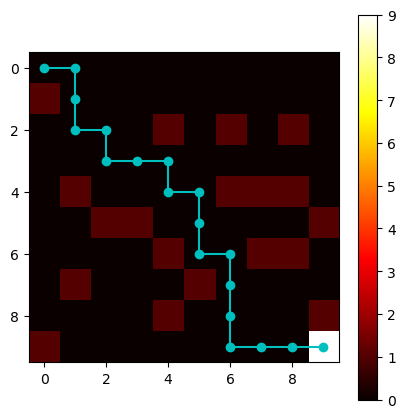

In [16]:
mostrar_camino(inicio, tamanio, meta, laberinto, Q)